# Mouse Cell Atlas Dataset

## Packages

In [2]:
from math import comb
from random import sample, choices
from itertools import accumulate
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import os
import pickle
import torch
import scipy
import numpy as np
import anndata
from anndata import AnnData
from torch.utils.data import Dataset, DataLoader
import scanpy as sc
from scipy.sparse import csr_matrix

## Data Loading

In [3]:
mouse_cell_atlas_path = "/scratch/jeremy/data/tabula-muris-senis-facs_mars.h5ad"
processed_mouse_cell_atlas_path = "/scratch/jeremy/data/mouse_cell_atlas_processed_GEARS.h5ad"

In [4]:
mca_dataset = anndata.read_h5ad(mouse_cell_atlas_path)
mca_dataset

AnnData object with n_obs × n_vars = 148116 × 23341
    obs: 'FACS.selection', 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'cellid', 'free_annotation', 'method', 'mouse.id', 'plate', 'sex', 'subtissue', 'tissue', 'well', 'cell_ontology_class_reannotated', 'free_annotation_reannotated'

In [5]:
with open('/scratch/jeremy/data/graphs/raw/gene_to_id.pkl', 'rb') as handle:
    gene_list = pickle.load(handle)
gene_list = set(gene_list.keys())

In [6]:
gene_ids = [i for i,g in enumerate(mca_dataset.var_names) if g.upper() in gene_list]
gene_names = [g.upper() for i,g in enumerate(mca_dataset.var_names) if g.upper() in gene_list]

In [7]:
GEAR_mca_dataset = sc.AnnData(X=mca_dataset.X[:,gene_ids])
GEAR_mca_dataset.var_names = gene_names
GEAR_mca_dataset.obs_names = mca_dataset.obs_names
GEAR_mca_dataset.obs = mca_dataset.obs

## Data Processing

### Yale's Pipeline

In [8]:
def yale_preprocessing(dataset: AnnData, output_path:str):
    """
    Preprocessing steps used by Van Dijk Lab.
    
    :param dataset: AnnData object containing the single cell data.
    :param output_path: Location to save the dataset.
    
    """
    # Make gene names unique
    dataset.var_names_make_unique()
    dataset.layers['counts'] = dataset.X.copy()
    # Filter out cells which have less than 200 genes expressed
    sc.pp.filter_cells(dataset, min_genes=200)  
    # Filter out genes which are expressed in less than 3 cells
    sc.pp.filter_genes(dataset, min_cells=3)
    # Mark mitochondrial genes 
    dataset.var['mt'] = dataset.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
    # Calculate quality control metrics
    sc.pp.calculate_qc_metrics(dataset, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    # Additional Filtering steps
    dataset = dataset[dataset.obs.n_genes_by_counts < 4000, :]
    dataset = dataset[dataset.obs.pct_counts_mt < 20, :]
    # Normalize each cell expression to sum up to the same number
    sc.pp.normalize_total(dataset, target_sum=1e4)
    # Log transformation of entire cell x gene matrix
    sc.pp.log1p(dataset)
    # Calculate min and 99.9th percentile for min-max normalization
    csr_mat = csr_matrix(dataset.X)
    min_val = csr_mat.min()
    percentile_value = np.percentile(csr_mat.data, 99.9)
    dataset.X = (dataset.X - min_val) / (percentile_value - min_val)
    # Save preprocessed dataset
    dataset.write_h5ad(output_path)

In [8]:
yale_preprocessing(GEAR_mca_dataset,processed_mouse_cell_atlas_path)

/home/baffou/.conda/envs/CellLM/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [9]:
mca_dataset = anndata.read_h5ad(processed_mouse_cell_atlas_path)
mca_dataset 

AnnData object with n_obs × n_vars = 105276 × 8179
    obs: 'FACS.selection', 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'cellid', 'free_annotation', 'method', 'mouse.id', 'plate', 'sex', 'subtissue', 'tissue', 'well', 'cell_ontology_class_reannotated', 'free_annotation_reannotated', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p'
    layers: 'counts'

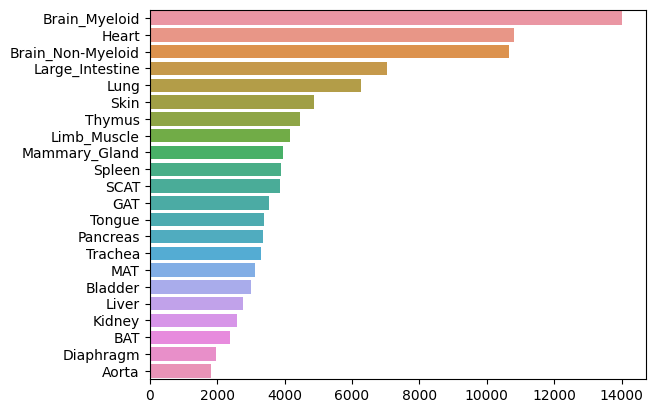

In [10]:
tissues_dist = mca_dataset.obs.tissue.value_counts().to_dict()
fig,ax = plt.subplots()
sns.barplot(x=list(tissues_dist.values()), y=list(tissues_dist.keys()),ax=ax);

### Tissue-Based Split

In [11]:
def create_split(dataset:AnnData, test_tissues:set, tissue_obs_id=str) -> tuple:
    """
    Split the main dataframe in two smaller ones based on the tissue of the cells.
    
    :param dataset: AnnData object containing the single cell data.
    :param test_tissues: Set of tissues to keep for the test set.
    :param tissue_obs_id: Key to retrieve tissue for each cell.
    
    :return: Tuple in the form (training dataset, test dataset)
    
    """
    # Create new meta DataFrames
    meta = dataset.obs
    meta["var_id"] = np.arange(len(meta))
    train_meta = meta[~meta[tissue_obs_id].isin(test_tissues)]
    test_meta = meta[meta[tissue_obs_id].isin(test_tissues)]
    print(f"The train-test split is {100*len(train_meta)/len(meta):.3f}% for training ",end="")
    print(f"and {100*len(test_meta)/len(meta):.3f}% for testing.")
    # Retrieve cell expressions 
    train_X = dataset.X[train_meta.var_id.values,:]
    test_X = dataset.X[test_meta.var_id.values,:]
    # Create Train dataset
    train_dataset = anndata.AnnData(X=train_X,obs=train_meta)
    train_dataset.var_names = dataset.var_names
    train_dataset.obs_names = dataset.obs_names[~meta[tissue_obs_id].isin(test_tissues)]
    train_dataset.obs = train_meta
    # Create Test dataset
    test_dataset = anndata.AnnData(X=test_X,obs=test_meta)
    test_dataset.var_names = dataset.var_names
    test_dataset.obs_names = dataset.obs_names[meta[tissue_obs_id].isin(test_tissues)]
    test_dataset.obs = test_meta
    return (train_dataset,test_dataset)

def sparsify_and_write(dataset:AnnData, path:str):
    """
    Convert the expression data in sparse matrix and write in h5ad format.
    
    :param dataset: AnnData object containing the single cell data.
    :param path: Location to save the dataset.
    
    """
    dataset.X = csr_matrix(dataset.X)
    dataset.write_h5ad(path)
    
def split_pipeline(dataset_path:str, test_tissues:set, output_path:str,
                   tissue_obs_id='tissue', output_suffix=''):
    """
    Pipeline to split the original dataset according to specified tissues.
    
    :param dataset_path: Location of the original dataset.
    :param test_tissues: Set of tissues to keep for the test set.
    :param output_path: Location to save the datasets.
    :param tissue_obs_id: Key to retrieve tissue for each cell. (Default='tissue').
    :param output_suffix: Suffix to append at the end of both training and test files. (Default='').
    
    """
    # Load Data
    dataset = anndata.read_h5ad(dataset_path)
    if tissue_obs_id not in dataset.obs_keys():
        raise ValueError("The provided key for the tissue is not in the dataset.")
    if isinstance(dataset.X, csr_matrix):
            dataset.X = dataset.X.toarray().astype(np.float32)
    # Create Split
    train_set, test_set = create_split(dataset, test_tissues, tissue_obs_id)
    # save Data
    output_suffix = "_".join(test_tissues)+output_suffix+".h5ad"
    sparsify_and_write(train_set, os.path.join(output_path,'train_'+output_suffix))
    sparsify_and_write(test_set, os.path.join(output_path,'test_'+output_suffix))

In [12]:
test_tissues = {'Kidney','Lung'}

In [13]:
split_pipeline(processed_mouse_cell_atlas_path, test_tissues, "/scratch/jeremy/data/",output_suffix="_GEARS")

The train-test split is 91.587% for training and 8.413% for testing.


---